<a href="https://colab.research.google.com/github/sharvaniyadav/Automated-Component-Detection-in-PCB-Manufacturing-Using-YOLOv8-Project-3/blob/main/Automated_Component_Detection_in_PCB_Manufacturing_Using_YOLOv8_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Drive is already mounted.


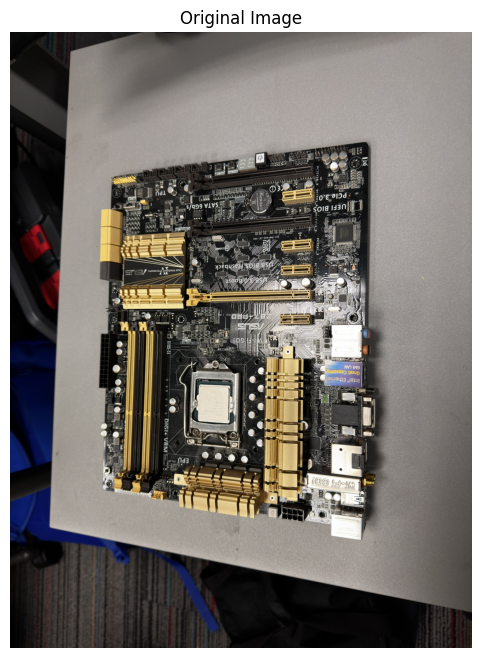

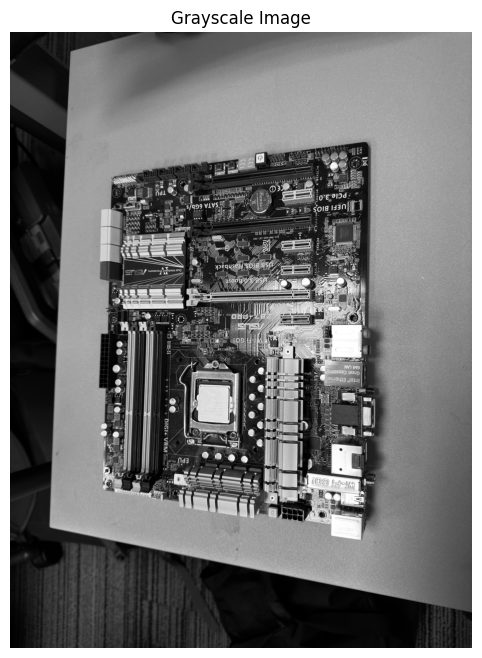

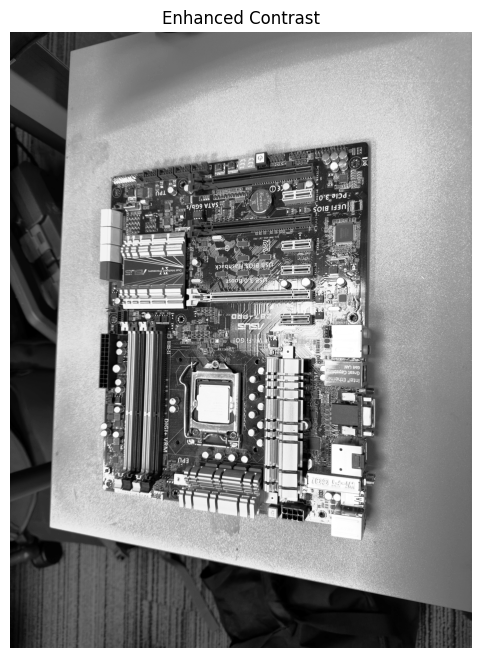

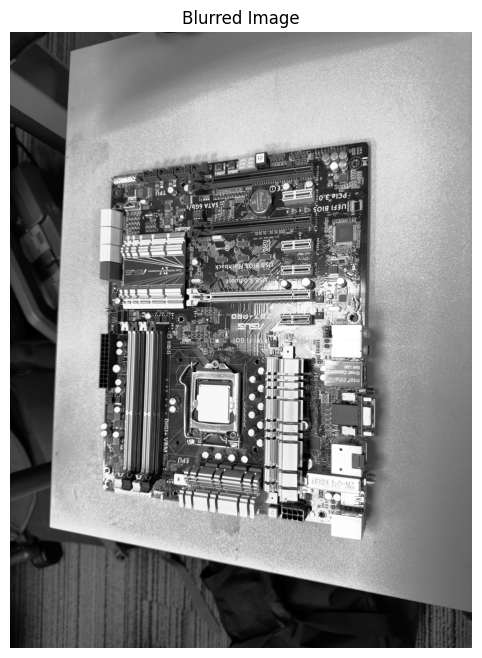

In [3]:
# Install Required Libraries
!pip install opencv-python-headless matplotlib Pillow --quiet

# Import Libraries
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

'''Step 1: Object Masking'''

# Step 1.1: Check and Mount Google Drive to Access the Dataset
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

# Step 1.2: Define the Path to Your Image and Load It
image_path = '/content/drive/MyDrive/data/motherboard_image.JPEG'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if image is None:
    raise FileNotFoundError(f"Image at {image_path} could not be loaded. Check the file path.")

# Display the Original Image
plt.figure(figsize=(8, 8))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Step 1.3: Convert to Grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display Grayscale Image
plt.figure(figsize=(8, 8))
plt.title("Grayscale Image")
plt.imshow(grayscale_image, cmap='gray')
plt.axis("off")
plt.show()

# Step 1.4: Enhance Contrast
contrast_enhanced_image = cv2.equalizeHist(grayscale_image)

# Display Enhanced Contrast Image
plt.figure(figsize=(8, 8))
plt.title("Enhanced Contrast")
plt.imshow(contrast_enhanced_image, cmap='gray')
plt.axis("off")
plt.show()

# Step 1.5: Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(contrast_enhanced_image, (5, 5), 0)

# Display Blurred Image
plt.figure(figsize=(8, 8))
plt.title("Blurred Image")
plt.imshow(blurred_image, cmap='gray')
plt.axis("off")
plt.show()
